# Write-up and code for Jan 30

## To Do
- ~~Implement Black-Scholes formulas for European Call/Put Pricing~~
- ~~Implement standard binary tree/grid-based numerical algorithm for American Option Pricing and ensure it validates against Black-Scholes formula for Europeans~~
- Implement Longstaff-Schwartz Algorithm and ensure it validates against binary tree/grid-based solution for path-independent options
- Explore/Discuss an Approximate Dynamic Programming solution as an alternative to Longstaff-Schwartz Algorithm

## Black-Scholes formulas
According the the Black-Scholes Equation the price of an option is described by
$$ 
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2S^2\frac{\partial^2V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$
Where
- $S(t)$ is the price of the underlying asset
- $V(S,t)$ is the price of the option
- $\sigma$ is the standard deviation of the return for the underlying asset
- $r$ is the risk-free interest rate

Solving this equation for a European Call Option gives us
$$
\begin{align}
C(S_t, t) & = N(d_1) S_t - N(d_2) PV(K)\\
d_1 & = \frac{1}{\sigma\sqrt{T-t}}\Big[ ln\big( \frac{S_t}{K}\big) + \big( r + \frac{\sigma^2}{2}\big)(T-t)\big) \Big]\\
d_2 & = d_1 - \sigma\sqrt{T-t}\\
PV(K) & = Ke^{-r(T-t)}
\end{align}
$$

Using the put-call parity then gives us the price of a European Put Option

$$
\begin{align}
P(S_t,t) & = Ke^{-r(T-t)} - S_t + C(S_t,t)\\
& = N(-d_2)Ke^{-r(T-t)} - N(-d1)S_t
\end{align}
$$

Where
- $N(\cdot)$ is the cdf for a standard normal distribution
- $K$ is the strike price
- $T-t$ is the time left to maturity

The following code finds the price using the equations above:

In [7]:
from typing import NamedTuple

class EuropeanOption(NamedTuple):
    call: bool # true if call option, false if put
    S: float # underlying asset price
    K: float # strike price
    sigma: float # standard deviation of the return for the stock price
    tau: float # time to maturity (T-t), in years
    r: float # annual interest rate

In [53]:
import numpy as np
from scipy.stats import norm

def Black_Scholes_Price(option: EuropeanOption) -> float:
    # function to calculate the Black-Scholes price for a European Option
    if option.call:
        # return the price of a european call option
        return norm.cdf(d1(option))*option.S - norm.cdf(d2(option))*PV(option)*option.K
    
    return norm.cdf(-d2(option))*PV(option)*option.K - norm.cdf(-d1(option))*option.S


def d1(option: EuropeanOption) -> float:
    # function to calculate the intermediate value d1 in the Black-Scholes formula
    return 1/(option.sigma * np.sqrt(option.tau))*(np.log(option.S/option.K) + (option.r + option.sigma**2/2)*option.tau)
    
    
def d2(option: EuropeanOption) -> float:
    # function to calculate the intermediate value d2 in the Black-Scholes formula
    return d1(option) - option.sigma*np.sqrt(option.tau)


def PV(option: EuropeanOption) -> float:
    # function to calculate the discount factor
    return np.exp(-option.r*option.tau)

In [55]:
euro_call = EuropeanOption(True, 100, 110, 0.25, 0.5, 0.05)
euro_put = EuropeanOption(False, 100, 110, 0.25, 0.5, 0.05)
print("Price for European call: ", Black_Scholes_Price(euro_call))
print("Price for European put: ", Black_Scholes_Price(euro_put))

Price for European call:  4.22578239296007
Price for European put:  11.509872716076657


## Binary Tree implementation for pricing of American Options
We will construct a binary tree which can then be used to recursively find the price of an American Option.
- We start with an initial stock price of $S_0$
- At each time step $t$ we can either move up to $S_t = S_{t-1} \cdot u$ or down to $S_t = S_{t-1}\cdot d$. Where $u = e^{\sigma\sqrt{\Delta t}}$ and $d = e^{-\sigma\sqrt{\Delta t}} = \frac{1}{u}$
- At maturity the price of the option is equal to the payoff, $\max(S_T - K, 0)$ for a call option, and $\max(K-S_T,0)$ for a put option
- For an American option, we have that at each preceding state the value of the option is $\max(\textit{binomial value, exercise value})$, where binomial value is the discounted expected value of the next state, i.e. $C(S_t, t) = \gamma\mathbb E[C(S_{t+1},t+1)~|~S_t]$
- The probability of an upwards movement is given by $p = \frac{e^{(\mu-q)\Delta t}  - d}{u - d}$ where $q$ is the dividend yield for the underlying asset

In [50]:
class Option(NamedTuple):
    call: bool # true if call option, false if put
    american: bool # true if american option, false if european
    S: float # underlying asset price
    K: float # strike price
    sigma: float # standard deviation of the return for the stock price
    tau: float # time to maturity (T-t), in years
    r: float # annual interest rate
    q: float #dividend yield

In [66]:
def Binary_Tree(option: Option, steps: int) -> float:
    # function that recursively finds the price of an American option
    assert(steps >= 0)
    
    delta_t = option.tau / steps
    up = np.exp(option.sigma*np.sqrt(delta_t))
    down = 1 / up
    # probability of upwards movement
    p = (np.exp((option.r - option.q)*delta_t)- down)/(up - down)
    
    # calculate the discount rate per time step
    gamma = np.exp(-option.r*delta_t)
    
    return binary_tree_helper(gamma, p, option.S, up, down, option, steps)


def binary_tree_helper(gamma: float, p: float, s: float, up: float, down: float, option: Option, steps: int) -> float:
    # helper function to calculate the option price
    # feed in the price
    if steps <= 0:
        # we have reached the end
        if option.call:
            return np.maximum(s-option.K, 0)
        return np.maximum(option.K - s, 0)
    
    # recursively find the price of the next step
    price_up = binary_tree_helper(gamma, p, s*up, up, down, option, steps - 1)
    price_down = binary_tree_helper(gamma, p, s*down, up, down, option, steps - 1)
    
    if option.american:
        # check if option is american
        if option.call:
            # check if call option
            return np.maximum(gamma*(p*price_up + (1-p)*price_down), s - option.K)
        return np.maximum(gamma*(p*price_up + (1-p)*price_down), option.K - s)
    
    # if it reaches here it is a european option
    return gamma*(p*price_up + (1-p)*price_down)

In [64]:
euro_call = Option(True, False, 100, 110, 0.25, 0.5, 0.05, 0)
euro_put = Option(False, False, 100, 110, 0.25, 0.5, 0.05, 0)
print("Price for European call: ", Binary_Tree(euro_call, 10))
print("Price for European put: ", Binary_Tree(euro_put, 10))

Price for European call:  4.207057860244597
Price for European put:  11.491148183361096


As we can see, using a binary grid converges quickly and produces roughly the same answer as Black-Scholes using only 10 time-steps between now and maturity.

In [201]:
am_call = Option(True, True, 100, 110, 0.25, 0.5, 0.05, 0)
am_put = Option(False, True, 100, 110, 0.25, 0.5, 0.05, 0)
print("Price for American call: ", Binary_Tree(am_call, 10))
print("Price for American put: ", Binary_Tree(am_put, 20))

Price for American call:  4.207057860244597
Price for American put:  12.151536447011493


We see that for an American put the price is slightly higher, than the price of the corresponding European put. The American Call produces the same price as the European Call, I don't know if this makes sense or not.

## Longstaff-Schwartz Algorithm
The essence of the Longstaff-Schwartz alogrithm is to use Monte-Carlo simulation of the underlying, combined with a linear regression to determine the value of not exercising. The maximum value of holding on to the option versus exercising will then correspond to the value of the option at that moment.

In [184]:
def monte_carlo_stock(option: Option, m: int, n: int) -> np.ndarray:
    # takes in an option and creates m Monte-Carlo price path simulations of the underlying, for n time-steps
    # mu is the drift of the underlying
    
    #initialize the stock price matrix and set the first value to be the value of the underlying
    S = np.zeros((m,n+1))
    S[:,0] = option.S
    
    # simulate a matrix of returns
    returns = np.random.normal((option.r/(option.tau*n)),option.sigma/np.sqrt(option.tau*n), (m,n))
    
    for j in range(1, n+1):
        # start at 1 since we have S_0, and then simulate n time-steps
        S[:,j] = S[:,j-1]*np.exp(returns[:,j-1])

    return S

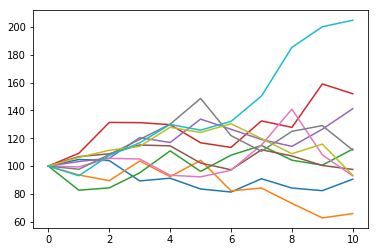

In [185]:
import matplotlib.pyplot as plt

s = monte_carlo_stock(am_call, 10, 10)
plt.plot(s.T)
plt.show()

In [192]:
def longstaff_schwartz(option: Option, m: int, n: int) -> float:
    # uses the longstaff-schwartz algorithm to return the value of an american option
    
    # initialize the value function
    cf = np.zeros((m,1))
    # simulate the stock price
    SP = monte_carlo_stock(option, m, n)
    
    # set the initial value of the value function to the payoff at maturity
    cf = payoff(SP[:,-1], option)
    
    # recursively backtrack the value of the option
    for j in range(n-1,1,-1):
        cf *= np.exp(-option.r*option.tau/n)
        
#         # we have 4 features in X
#         X = np.zeros((m,4))
#         Y = np.zeros((m,1))
#         for i in range(m):
#             # only add features if the payoff at current state is > 0 
#             if payoff(SP[i,j], option) > 0:
#                 X[i,:] = feature_func(SP[i,j], option)
#                 Y[i] = cf[i]

        X = feature_func(SP[payoff(SP[:,j], option) > 0, j], option)
        Y = cf[payoff(SP[:,j], option) > 0]

        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), Y)
        
        for i in range(m):
            if payoff(SP[i,j], option) > np.matmul(feature_func(SP[i,j], option),w):
                cf[i] = payoff(SP[i,j], option)
                
    exercise = payoff(option.S, option)
    cont = np.mean(cf)*np.exp(-option.r*option.tau/n)
    
    return np.maximum(exercise, cont)


def feature_func(s: Union[float, np.ndarray], option: Option) -> np.ndarray:
    # takes in price of underlying and an option and returns a feature function
    sp = np.divide(s, option.K).reshape(-1,1)
    
    phi_0 = np.ones((np.size(sp),1))
    phi_1 = np.exp(-sp/2)
    phi_2 = np.multiply(np.exp(-sp/2), 1 - sp)
    phi_3 = np.multiply(np.exp(-sp/2), 1 - 2*sp + np.square(sp)/2)

    return np.concatenate((phi_0, phi_1, phi_2, phi_3), axis=1)


def payoff(s: Union[float, np.ndarray], option: Option) -> Union[float, np.ndarray]:
    # returns the payoff for an american option given price of underlying is s
    if option.call:
        return np.maximum(s - option.K, 0)
    
    return np.maximum(option.K - s, 0)

In [198]:
print("Price for American call: ", longstaff_schwartz(am_call, 10000, 100))
print("Price for American put: ", longstaff_schwartz(am_put, 10000, 100))

Price for American call:  0.9904131417240793
Price for American put:  13.713782085327535


In [199]:
print("Price for American call: ", longstaff_schwartz(am_call, 10000, 100))
print("Price for American put: ", longstaff_schwartz(am_put, 10000, 100))

Price for American call:  1.9893212259011641
Price for American put:  13.715583835489301
